In [438]:
'''!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chilledwanker/loan-approval-prediction")

print("Path to dataset files:", path)'''

'!pip install kagglehub\nimport kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("chilledwanker/loan-approval-prediction")\n\nprint("Path to dataset files:", path)'

In [439]:
# Import libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer,SimpleImputer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [440]:
# Extract dfs

df_train = pd.read_csv("Datasets/train.csv")
df_addition = pd.read_csv(r"Datasets\credit_risk_dataset.csv")
df_test = pd.read_csv("Datasets/test.csv")

In [441]:
df_train = df_train.set_index(df_train["id"])
df_train = df_train.drop("id",axis=1)

In [442]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [443]:
df_addition.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


In [444]:
df_train = pd.concat([df_train, df_addition], ignore_index=True)
df_train.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0


In [445]:
df_train.nunique()

person_age                      58
person_income                 4376
person_home_ownership            4
person_emp_length               38
loan_intent                      6
loan_grade                       7
loan_amnt                      759
loan_int_rate                  388
loan_percent_income             78
cb_person_default_on_file        2
cb_person_cred_hist_length      29
loan_status                      2
dtype: int64

In [446]:
print(df_train.duplicated().sum())
df_train = df_train.drop_duplicates().reset_index(drop=True)
print(df_train.duplicated().sum())

165
0


In [447]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91061 entries, 0 to 91060
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91061 non-null  int64  
 1   person_income               91061 non-null  int64  
 2   person_home_ownership       91061 non-null  object 
 3   person_emp_length           90174 non-null  float64
 4   loan_intent                 91061 non-null  object 
 5   loan_grade                  91061 non-null  object 
 6   loan_amnt                   91061 non-null  int64  
 7   loan_int_rate               87966 non-null  float64
 8   loan_percent_income         91061 non-null  float64
 9   cb_person_default_on_file   91061 non-null  object 
 10  cb_person_cred_hist_length  91061 non-null  int64  
 11  loan_status                 91061 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.3+ MB


En esta sección veo que el porcentaje del interes del credito esta ausente en algunas columnas, así como la duración de las personas en su empleo actual, por las demás columnas todo correcto 

In [448]:
df_train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91061.000000,9.106100e+04,90174.000000,91061.000000,87966.000000,91061.000000,91061.000000,91061.000000
mean,27.620683,6.477432e+04,4.732306,9351.508352,10.791001,0.163158,5.812752,0.169546
std,6.150047,4.792286e+04,4.025893,5848.017127,3.109323,0.097486,4.039820,0.375235
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.950000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


Es interesante observar que el target **loan_status** esta desbalanceado, y algunas edades son outliers, también en la longitud de el empleo actual del cliente, 123 es un número outlier pues la media es de 4.73 años aprox.

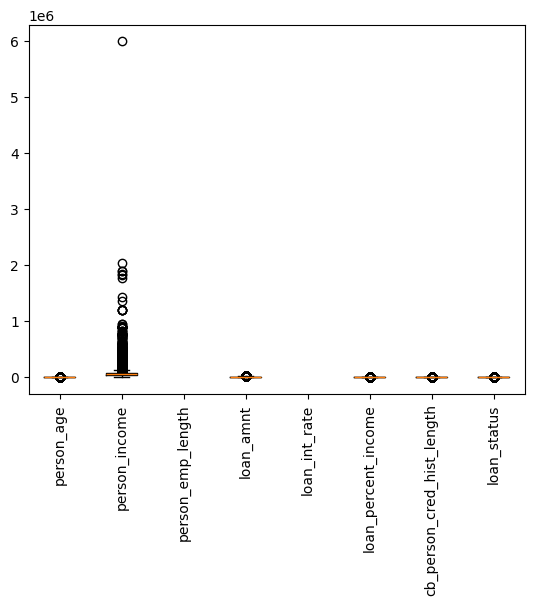

In [449]:
num_cols = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "loan_status"]
plt.boxplot(df_train[num_cols], tick_labels=num_cols)
plt.xticks(rotation=90)
plt.show()

## Outlier Detetion


Voy a identificar los outliers, especifico seleccione 2 columnas, **person_age** puesto que el 75% de los datos tiene menos de 30 años y el maximos es 144 lo cual es irreal. En segundo lugar la columna **person_emp_length** tiene como el 75% de los datos menor a 7 años de empleabilidad en el ultimo trabajo de los clientes registrados y se tiene como maximo 123 lo cual no es posible. 

In [450]:
train_df = df_train.copy()

train_df['Z_Score'] = abs(stats.zscore(train_df['person_age']))

train_df = train_df[train_df['Z_Score'] < 4.5]

train_df = train_df.drop('Z_Score', axis=1)

print(train_df.shape)

(90720, 12)


Para la columna de el tiempo de empleo rellenare la columna para que la función de *zscore()* pueda funcionar correctamente, utilizare un **KNNImputer**, un relleno por vecinos. 

In [451]:
knn_imp = KNNImputer(n_neighbors=5)
train_df["person_emp_length"] = knn_imp.fit_transform(train_df[["person_emp_length"]])

In [452]:
train_df['Z_Score'] = abs(stats.zscore(train_df['person_emp_length']))

train_df = train_df[train_df['Z_Score'] < 4.5]

train_df = train_df.drop('Z_Score', axis=1)

print(train_df.shape)

(90609, 12)


In [453]:
train_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,90609.000000,9.060900e+04,90609.000000,90609.000000,87534.000000,90609.000000,90609.000000,90609.000000
mean,27.470020,6.460936e+04,4.700167,9348.478650,10.789987,0.163186,5.737278,0.169387
std,5.705913,4.267179e+04,3.846106,5843.703223,3.108740,0.097474,3.882610,0.375096
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.950000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,55.000000,2.039784e+06,22.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


El .describe() ha mejorado bastante, ahora haremos un analisis de correlaciones con loan_status

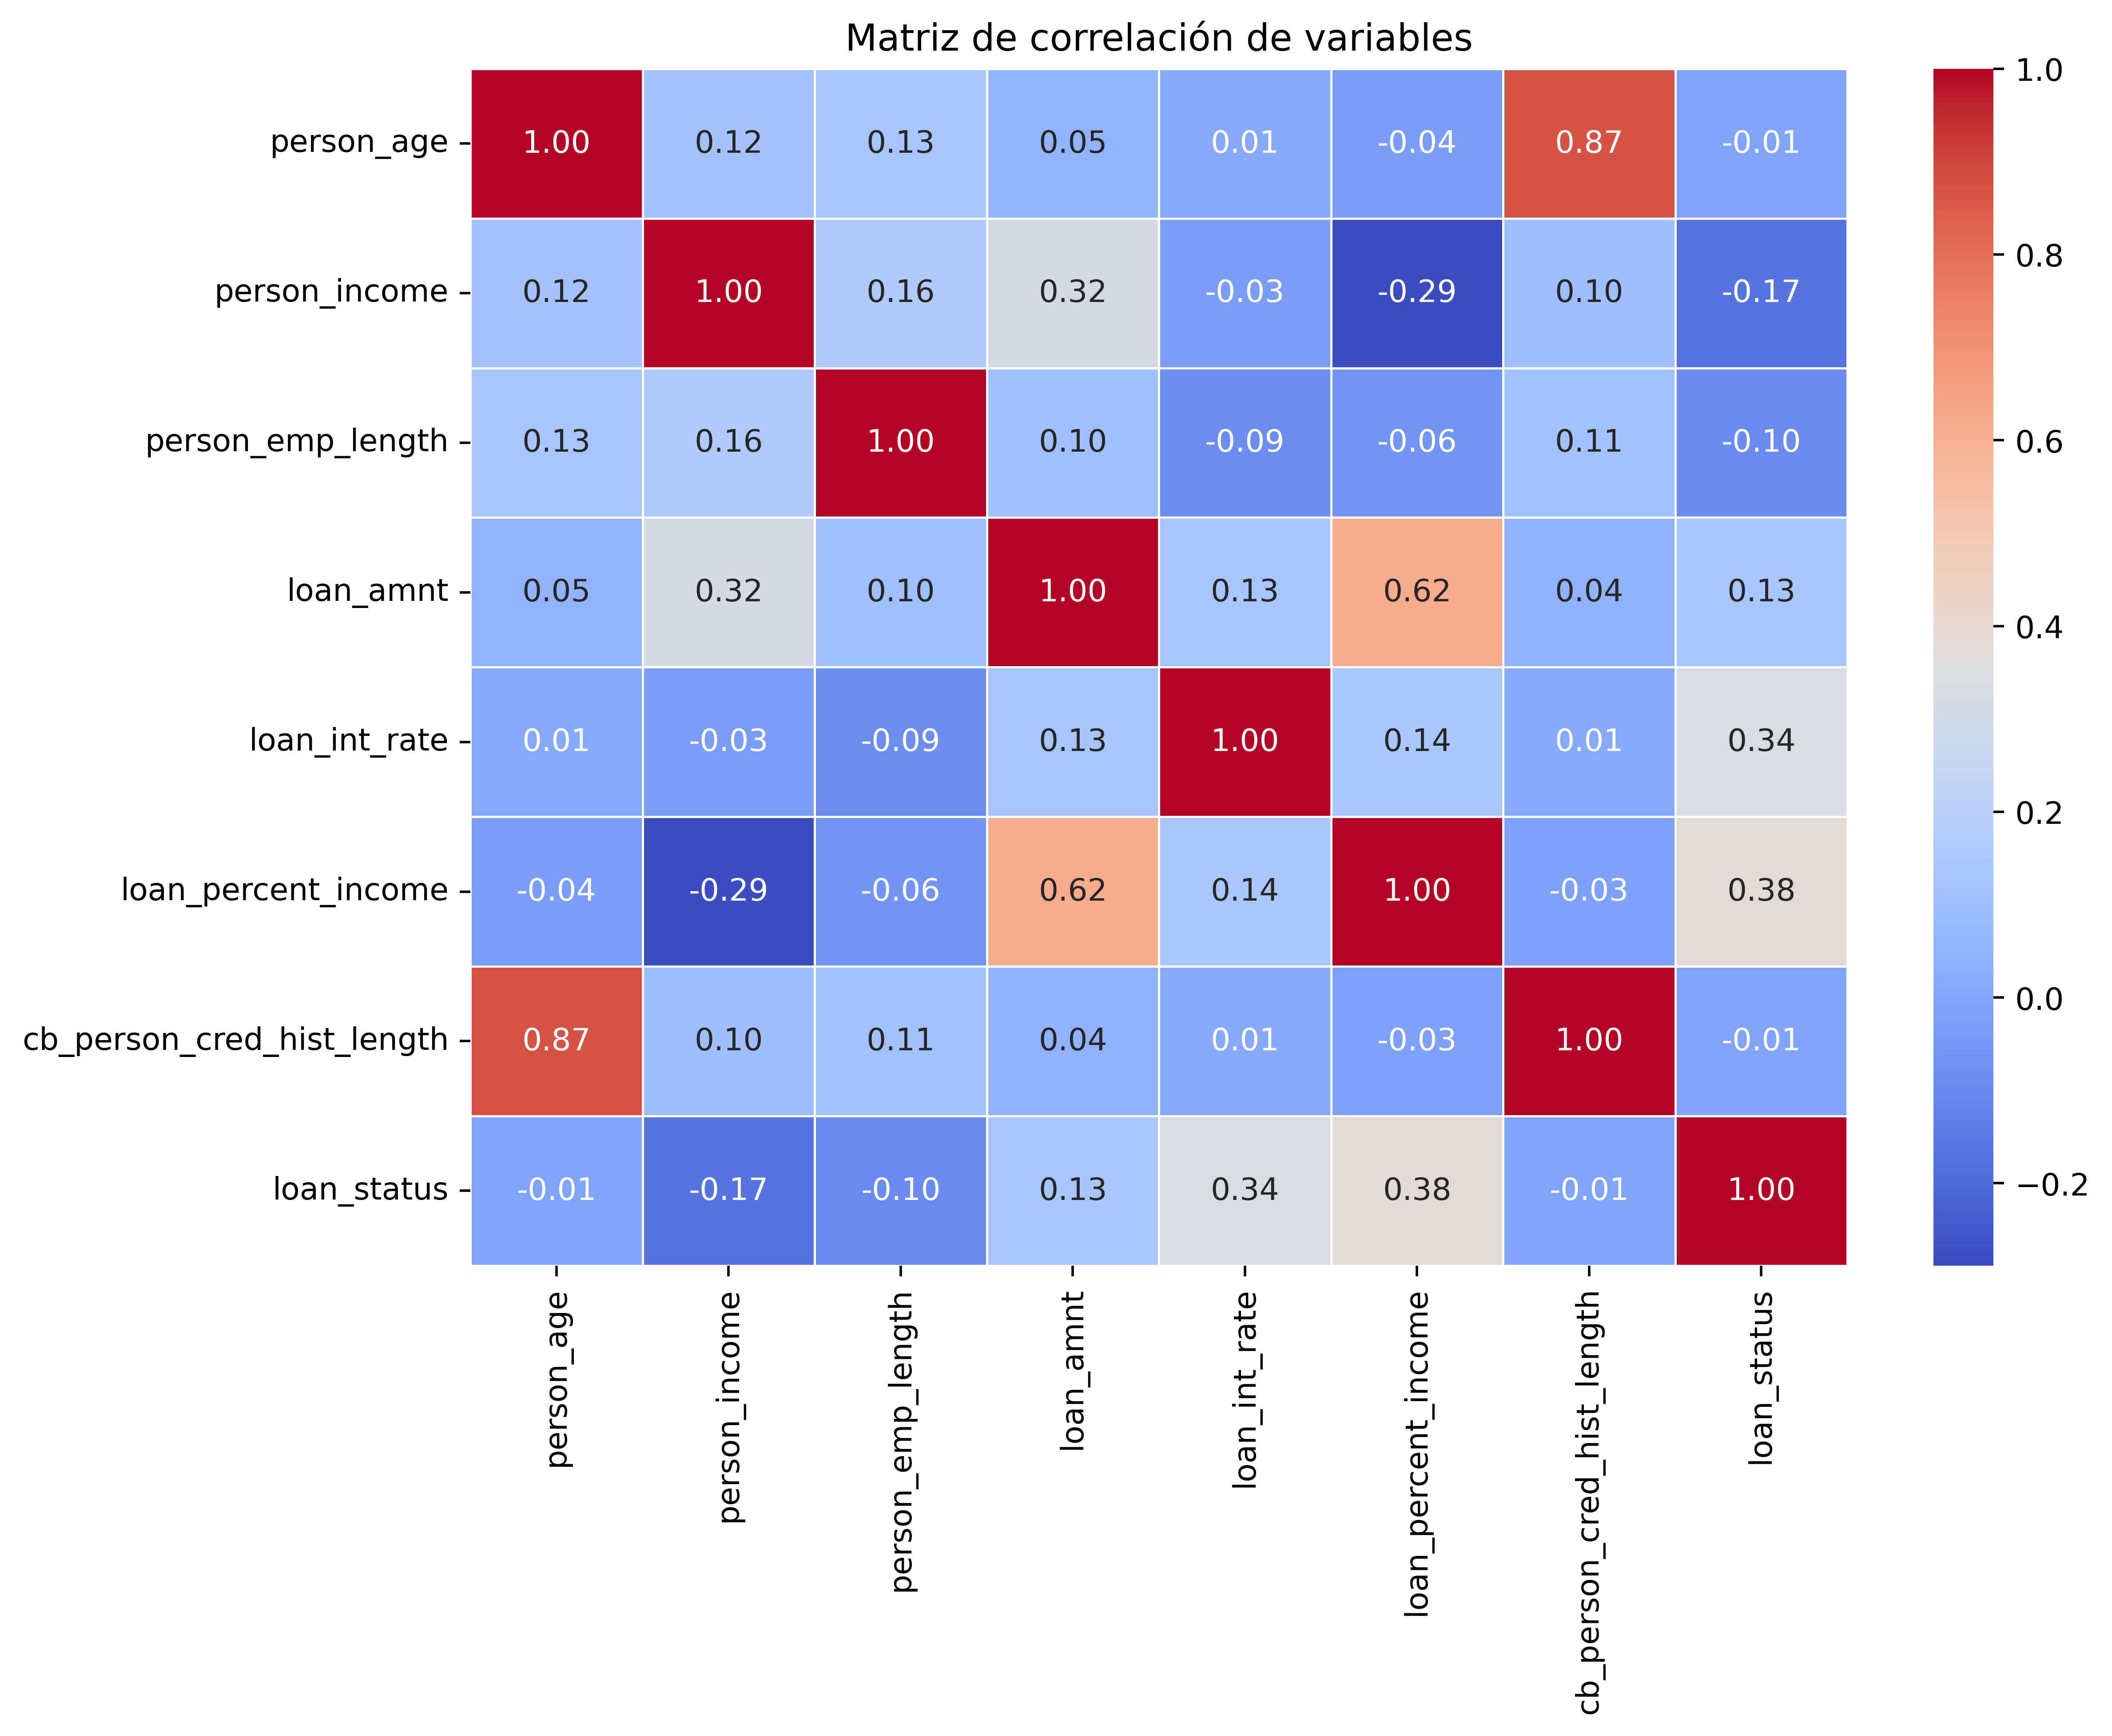

In [454]:
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de correlación
corr_matrix = train_df[num_cols].corr()

# Heat map
plt.figure(figsize=(10, 7), dpi=500)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación de variables")
plt.show()


Se observan cosas interesantes en el heatmap, en primer lugar hay una correlación esperada de 0.87 entre la edad de la persona y su historial crediticio, también vemos una correlación fuerte entre el porcentaje de de ingresos de la persona que se destina a la deuda y la cantidad del prestamo, mucho sentido también

Por otro lado también vemos ciertas correlaciones inversas no tan fuertes.

Lo que nos concierne aquí son la correlaciones que nos llegan a interesar para poder saber el **loan_status**, siendo el porcentaje del ingreso que se destina al pago de la deuda la correlación más alta, 0.38 y el segundo es la tasa de interes de prestamo, también hay una corre lación inversa entre el ingreso de la persona y el loan_status del -0.17

## Preprocesamiento para el modelo

In [455]:
targets_train = train_df["loan_status"]
features_train = train_df.drop("loan_status", axis=1)

features_test = df_test.copy()

In [456]:

numerical_cols = features_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = features_train.select_dtypes(include=["object"]).columns.tolist()

In [457]:
categorical_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [458]:
ordinal_features = ['loan_grade']
ordinal_features = [col for col in ordinal_features if col in features_train.columns]

nominal_features = list(set(categorical_cols) - set(ordinal_features))

In [459]:
print(df_train["loan_grade"].unique())

['B' 'C' 'A' 'D' 'E' 'F' 'G']


## Creación del pipeline para las caracteristicas

In [460]:
# Numerical  type
num_feature = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

# Nominal type 

nom_feature = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder())
])

# Ordinal type

ord_feature = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']], 
                                       dtype=int))
])

In [461]:
# Aplicación de pipeline

preprocess = ColumnTransformer(transformers=[
    ('num', num_feature, numerical_cols),
    ('nom', nom_feature, nominal_features),
    ('ord', ord_feature, ordinal_features)
])

In [462]:

features_train = preprocess.fit_transform(features_train)
features_test = preprocess.transform(features_test)

In [463]:
print(features_train.shape)

(90609, 20)


### Split dataset

In [464]:
features_train, features_valid, targets_train, targets_valid = train_test_split(features_train, 
                                                                                targets_train, 
                                                                                test_size=0.2, 
                                                                                random_state=12345)

In [465]:
targets_train

counts = pd.Series(targets_train).value_counts()
print(counts)


loan_status
0    60110
1    12377
Name: count, dtype: int64


## Model

In [466]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
from scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight

In [467]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets_train), y=targets_train)

# Convierte los pesos a un diccionario que Keras acepta
class_weights_dict = dict(enumerate(class_weights))

In [468]:
def build_model(optimizer, activator, neurons_1, neurons_2):
    """
    Construye y compila un modelo de red neuronal secuencial con capas densas para clasificación binaria.

    Parámetros:
    -----------
    optimizer : str o tf.keras.optimizers.Optimizer
        El optimizador que se usará para la compilación del modelo (por ejemplo, 'adam' o 'rmsprop').

    activator : str o tf.keras.activations
        La función de activación que se usará en las capas ocultas (por ejemplo, 'relu' o 'tanh').

    neurons_1 : int
        Número de neuronas en la primera capa oculta densa.

    neurons_2 : int
        Número de neuronas en las segunda y tercera capas ocultas densas.

    Returns:
    --------
    model : tf.keras.models.Sequential
        El modelo de Keras compilado, listo para ser entrenado.
    
    Notas:
    ------
    - El modelo tiene una capa de entrada que se adapta al número de características en los datos de entrenamiento.
    - La última capa es una capa densa con activación 'sigmoid', adecuada para problemas de clasificación binaria.
    - La métrica de evaluación configurada es el AUC (Área bajo la curva ROC).
    """
    model = Sequential([
        Input(shape=(features_train.shape[1],)),
        Dense(neurons_1, activation=activator),
        Dense(neurons_2, activation=activator),
        Dense(neurons_2, activation=activator),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=['AUC'])
    return model


In [469]:
# Crear el KerasClassifier
model = KerasClassifier(model=build_model, verbose=1)

In [470]:
# Definir el grid de parámetros
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activator': ['relu', 'tanh'], 
    'model__neurons_1': [124, 64, 32],
    'model__neurons_2': [64, 32, 16],
    'epochs': [10, 20],
    'batch_size': [32, 64]
}

In [471]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)
grid_result = grid.fit(features_train, targets_train, class_weight=class_weights_dict)

Epoch 1/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.8781 - loss: 0.4302
Epoch 2/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9217 - loss: 0.3426
Epoch 3/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9248 - loss: 0.3318
Epoch 4/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9252 - loss: 0.3245
Epoch 5/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9310 - loss: 0.3151
Epoch 6/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9314 - loss: 0.3137  
Epoch 7/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - AUC: 0.9330 - loss: 0.3104
Epoch 8/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9312 - loss: 0.3123
Epoch 9/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 2s 1000us/step - AUC: 0.9334 - loss: 0.3040
Epoch 10/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9351 - loss: 0.3035
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step
Epoch 1/10
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.8778 - loss: 0.4310
Epoch 2/10
1511/1511 ━━━━━━━━━━━━━━━

C:\Users\evolu\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



2266/2266 ━━━━━━━━━━━━━━━━━━━━ 3s 818us/step - AUC: 0.8810 - loss: 0.4194
Epoch 2/10
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 2s 805us/step - AUC: 0.9207 - loss: 0.3377
Epoch 3/10
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 2s 824us/step - AUC: 0.9233 - loss: 0.3308
Epoch 4/10
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 2s 807us/step - AUC: 0.9285 - loss: 0.3189
Epoch 5/10
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step - AUC: 0.9279 - loss: 0.3206
Epoch 6/10
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 2s 799us/step - AUC: 0.9284 - loss: 0.3154
Epoch 7/10
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step - AUC: 0.9295 - loss: 0.3127
Epoch 8/10
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 2s 822us/step - AUC: 0.9303 - loss: 0.3124
Epoch 9/10
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 2s 799us/step - AUC: 0.9344 - loss: 0.3046
Epoch 10/10
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 2s 812us/step - AUC: 0.9340 - loss: 0.3040


In [472]:
print("Best AUC-ROC Score: ", grid_result.best_score_)
print("Best Parameters: ", grid_result.best_params_)

Best AUC-ROC Score:  0.9259341075002876
Best Parameters:  {'batch_size': 32, 'epochs': 10, 'model__activator': 'relu', 'model__neurons_1': 124, 'model__neurons_2': 32, 'model__optimizer': 'adam'}


In [485]:
best_model = grid_result.best_estimator_

final_pred = best_model.predict_proba(features_test)[:, 1]

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [486]:
results_df = pd.DataFrame({
    "id": df_test["id"],
    "loan_status": final_pred
})

In [488]:
# Guarda el archivo en formato CSV para enviarlo a Kaggle
results_df.to_csv("submission.csv", index=False)

In [490]:
import joblib

# Guarda el mejor modelo
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']